# **PyTorch Card Classifier**

We will tackle using PyTorch by focusing on these 3 parts:


*   How to use PyTorch datasets and data loaders
*   How to set up the PyTorch model based on NN
*   How to set up the PyTorch training loop



In [ ]:
import zipfile

zip_path = "archive.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("cards_classifier_model_data")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

TRAIN_DIR = '/content/cards_classifier_model_data/train'
TEST_DIR = '/content/cards_classifier_model_data/test'
VALID_DIR = '/content/cards_classifier_model_data/valid'

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
PyTorch version 2.8.0+cu126
Torchvision version 0.23.0+cu126
Numpy version 2.0.2
Pandas version 2.2.2


# Step 1. Setting up the dataset

In [ ]:
class PlayingCardDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    @property
    def classes(self):
        return self.data.classes

In [ ]:
dataset = PlayingCardDataset(
    data_dir=TRAIN_DIR
)
len(dataset)

7624

41


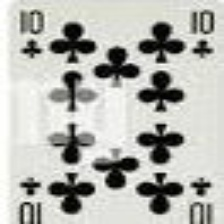

In [ ]:
image, label = dataset[6000]
print(label)
image

In [ ]:
# Get a dictionary associating target values with folder names
target_to_class = {v: k for k, v in ImageFolder(TRAIN_DIR).class_to_idx.items()}
print(target_to_class)

{0: 'ace of clubs', 1: 'ace of diamonds', 2: 'ace of hearts', 3: 'ace of spades', 4: 'eight of clubs', 5: 'eight of diamonds', 6: 'eight of hearts', 7: 'eight of spades', 8: 'five of clubs', 9: 'five of diamonds', 10: 'five of hearts', 11: 'five of spades', 12: 'four of clubs', 13: 'four of diamonds', 14: 'four of hearts', 15: 'four of spades', 16: 'jack of clubs', 17: 'jack of diamonds', 18: 'jack of hearts', 19: 'jack of spades', 20: 'joker', 21: 'king of clubs', 22: 'king of diamonds', 23: 'king of hearts', 24: 'king of spades', 25: 'nine of clubs', 26: 'nine of diamonds', 27: 'nine of hearts', 28: 'nine of spades', 29: 'queen of clubs', 30: 'queen of diamonds', 31: 'queen of hearts', 32: 'queen of spades', 33: 'seven of clubs', 34: 'seven of diamonds', 35: 'seven of hearts', 36: 'seven of spades', 37: 'six of clubs', 38: 'six of diamonds', 39: 'six of hearts', 40: 'six of spades', 41: 'ten of clubs', 42: 'ten of diamonds', 43: 'ten of hearts', 44: 'ten of spades', 45: 'three of clu

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)), # convert all images to the same size for the NN input layer
    transforms.ToTensor(),
])

dataset = PlayingCardDataset(TRAIN_DIR, transform)

In [ ]:
image, label = dataset[100]
image.shape

torch.Size([3, 128, 128])

In [ ]:
# DataLoader in PyTorch is used to efficiently feed data to the model during training so it's faster
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
for images, labels in dataloader:
  break
images.shape, labels.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

# Step 2. Pytorch Model
Pytorch datasets have a structured way of organizing your data, pytorch models follow a similar paradigm.


*   We could create the model from scratch defining each layer. However for tasks like image classification, many of the state of the art architectures are readily available and we can import them from packages like timm.
*   Understanding the pytorch model is all about understanding the shape the data is at each layer, and the main one we need to modify for a task is the final layer.
* Here we have 53 targets, so we will modify the last layer for this.



---



In TensorFlow/Keras, especially with the Sequential API, you usually define everything in one place: the pretrained backbone, flattening, and new classifier layers all in a single Sequential list.

PyTorch separates layer definition (__init__) from layer connection / forward pass (forward). That’s why here you have:

* self.base_model – holds the entire pretrained model.
* self.features – extracts only the backbone layers you want.
* self.classifier – your new head.

You then explicitly connect them in forward. In Keras, that separation is optional because the framework can automatically chain layers if you use Sequential, or you can use the Functional API for explicit control.

In [ ]:
class SimpleCardClassifer(nn.Module):
    def __init__(self, num_classes=53):
        super(SimpleCardClassifer, self).__init__()
        # Load a pretrained EfficientNet-B0 model from timm
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)

        # Take all layers of the EfficientNet except the last classification layer.
        # The last layer was trained for ImageNet (1000 classes), so we remove it to replace with our own.
        # This part extracts features from images (edges, textures, shapes, etc.).
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        # EfficientNet-B0 produces a 1280-dimensional feature vector at the end
        enet_out_size = 1280

        # Define the classifier head:
        # - Flatten: convert feature map into a single vector
        # - Linear: map the 1280 features to `num_classes` outputs (one score per class)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )

    def forward(self, x):
        # Defines how input data flows through the model (the "forward pass")
        # This is required in PyTorch to connect the layers; unlike Keras Sequential API,
        # PyTorch does not automatically chain layers.
        x = self.features(x)      # Extract features using the pretrained backbone
        output = self.classifier(x)  # Map features to class scores with the new linear layer
        return output


In [ ]:
model = SimpleCardClassifer(num_classes=53)
print(str(model)[:500])

SimpleCardClassifer(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=Fal


In [ ]:
example_out = model(images)
example_out.shape # [batch_size, num_classes]

torch.Size([32, 53])

# Step 3. Training Loop

In [ ]:
# Loss function
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_dataset = PlayingCardDataset(TRAIN_DIR, transform=transform)
val_dataset = PlayingCardDataset(VALID_DIR, transform=transform)
test_dataset = PlayingCardDataset(TEST_DIR, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

cuda:0


In [ ]:
# Simple training loop for PyTorch model - note in TF you don't do any of these manual steps (use .fit())
num_epochs = 5
train_losses, val_losses = [], []  # Lists to store loss history

# Set device to GPU if available, else CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize the model and move it to the device
model = SimpleCardClassifer(num_classes=53)
model.to(device)

# Define the loss function (Cross-Entropy for multi-class classification)
criterion = nn.CrossEntropyLoss()

# Define the optimizer (Adam) with learning rate 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # ------------------------
    # Training phase
    # ------------------------
    model.train()  # Set model to training mode (enables dropout, batchnorm updates)
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc='Training loop'):
        # Move input images and labels to the device
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()       # Clear previous gradients
        outputs = model(images)     # Forward pass: compute model predictions
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()             # Backpropagation: compute gradients
        optimizer.step()            # Update weights using optimizer
        running_loss += loss.item() * labels.size(0)  # Accumulate total loss for the epoch

    # Average training loss over all training samples
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # ------------------------
    # Validation phase
    # ------------------------
    model.eval()  # Set model to evaluation mode (disables dropout, batchnorm updates)
    running_loss = 0.0
    with torch.no_grad():  # No gradient computation needed for validation
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)             # Forward pass
            loss = criterion(outputs, labels)  # Compute validation loss
            running_loss += loss.item() * labels.size(0)

    # Average validation loss over all validation samples
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    # Print losses for this epoch
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/5 - Train loss: 1.6016740320486886, Validation loss: 0.35011584039004345


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/5 - Train loss: 0.5464384588965089, Validation loss: 0.24469688006167142


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/5 - Train loss: 0.35553098591152044, Validation loss: 0.22980753430780373


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/5 - Train loss: 0.2497261187055804, Validation loss: 0.12002836285897021


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/5 - Train loss: 0.19738437324285443, Validation loss: 0.15217199899115652


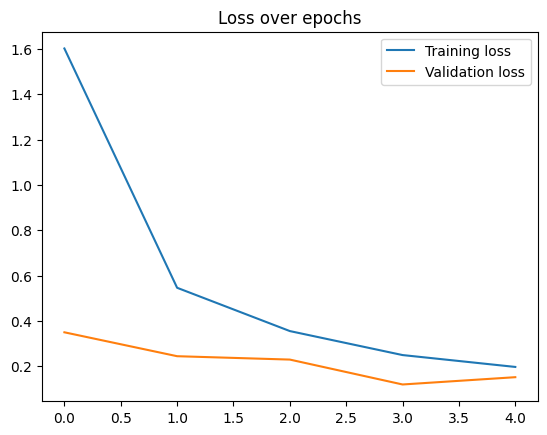

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

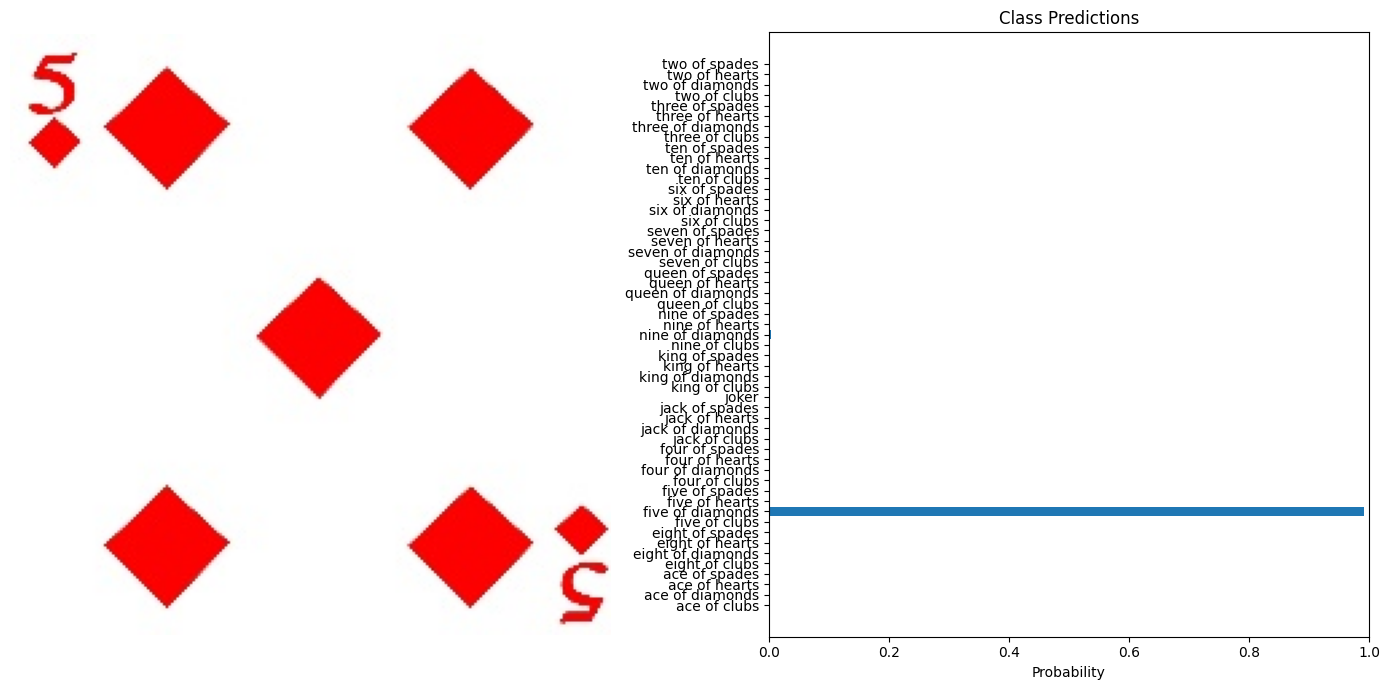

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))

    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")

    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# Example usage
test_image = f"{TEST_DIR}/five of diamonds/2.jpg"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

# Assuming dataset.classes gives the class names
class_names = dataset.classes
visualize_predictions(original_image, probabilities, class_names)